In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import pandas as pd
import numpy as np

import george
from george import kernels

import corner

In [2]:
datadir = "/Users/danielahuppenkothen/work/data/asteroid-ztf/"

In [3]:
d1 = pd.read_csv(datadir+"ztf_mags_0.txt", sep=" ")
d2 = pd.read_csv(datadir+"ztf_mags_1.txt", sep=" ")
d3 = pd.read_csv(datadir+"ztf_mags_2.txt", sep=" ")

<IPython.core.display.Javascript object>


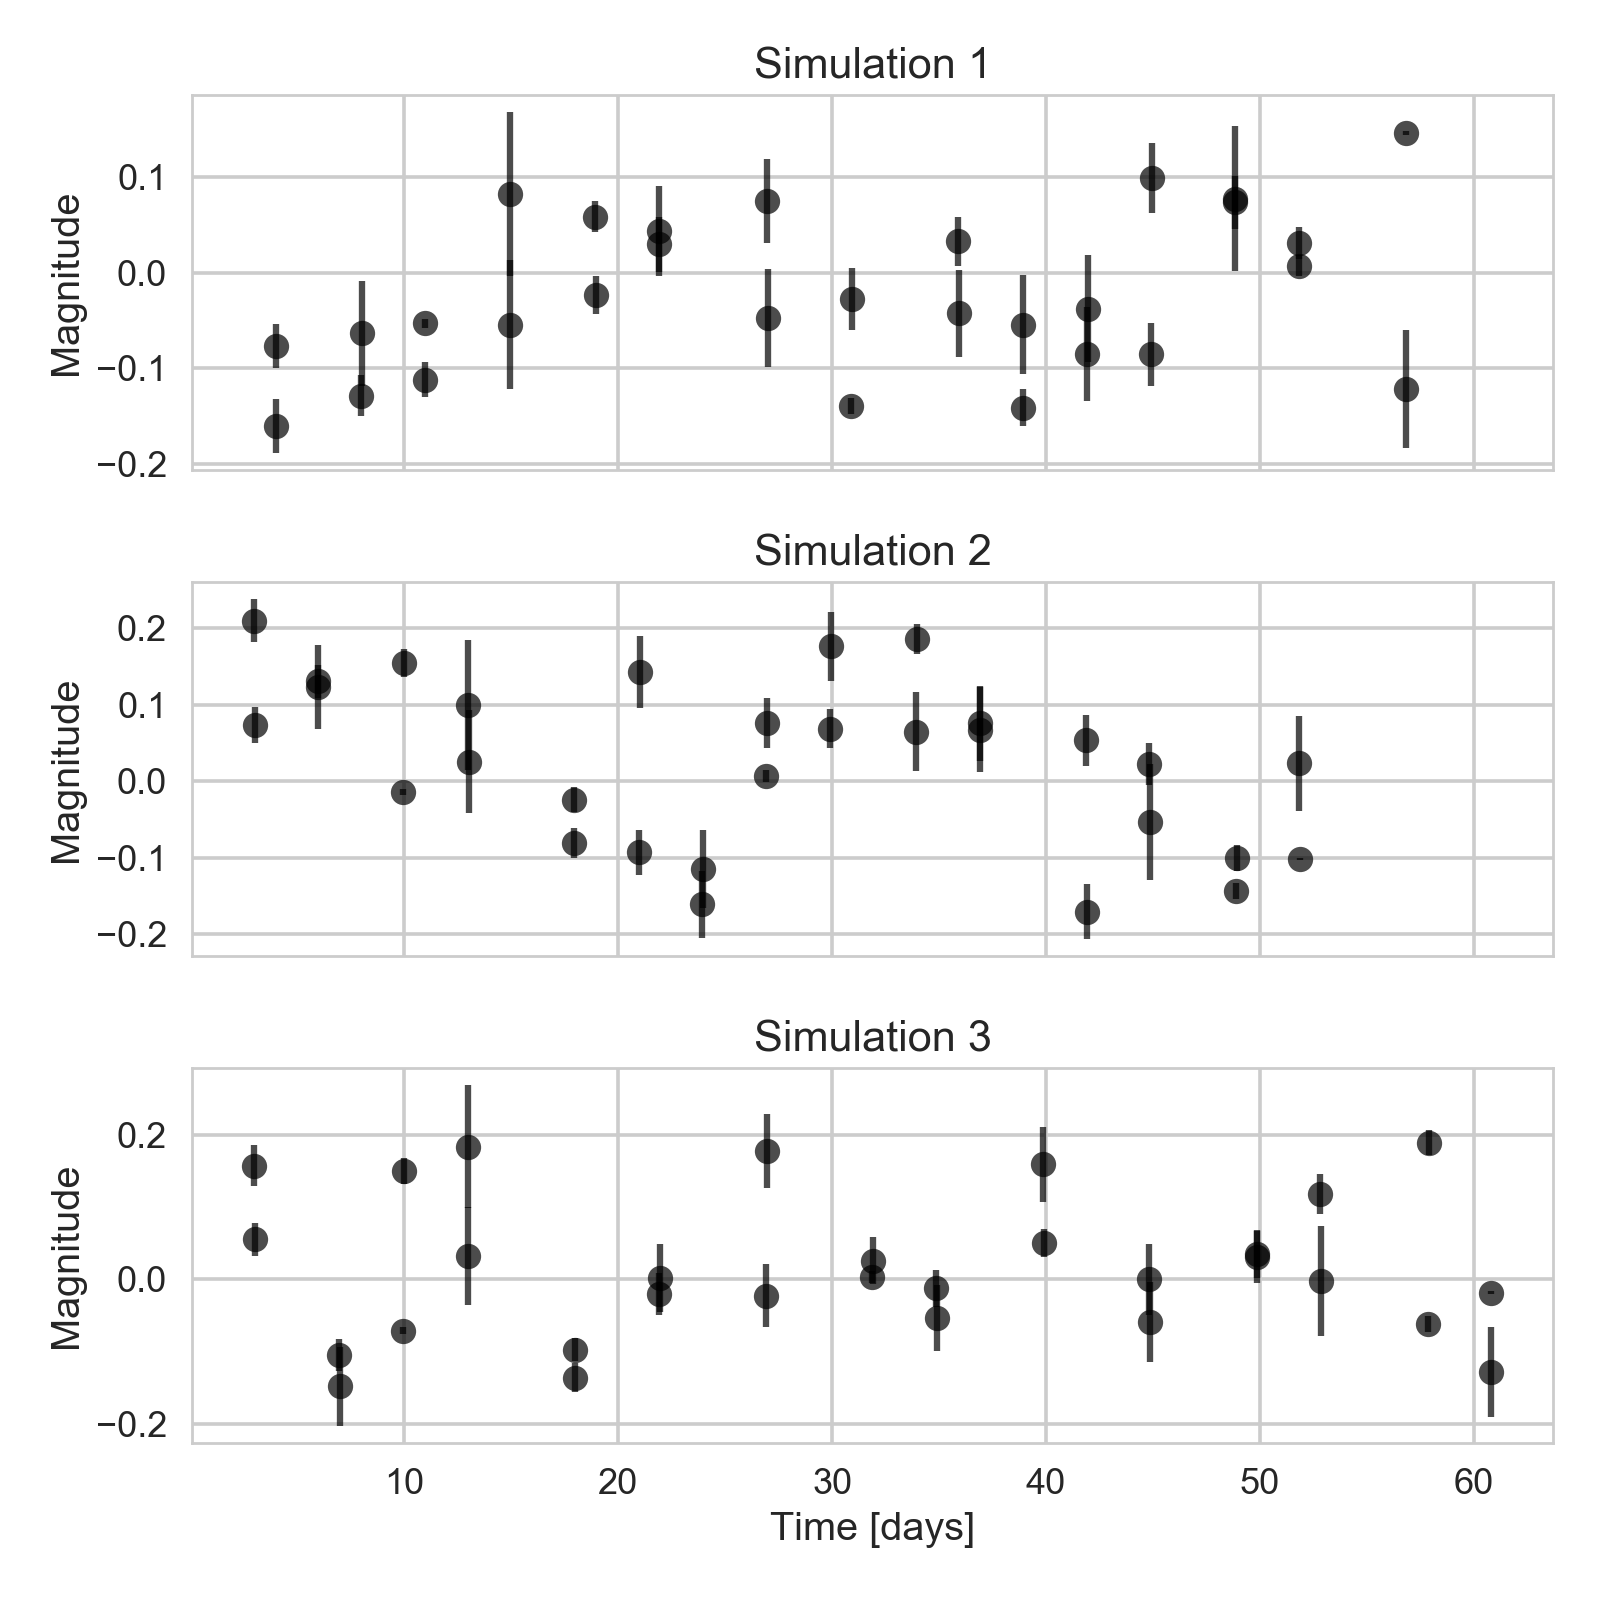

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,8), sharex=True)
ax1.errorbar(d1.Times, d1.Mags, yerr=d1.Mag_errs, fmt="o", c="black", alpha=0.7)
ax2.errorbar(d2.Times, d2.Mags, yerr=d1.Mag_errs, fmt="o", c="black", alpha=0.7)
ax3.errorbar(d3.Times, d3.Mags, yerr=d1.Mag_errs, fmt="o", c="black", alpha=0.7)
ax3.set_xlabel("Time [days]")
ax1.set_ylabel("Magnitude")
ax2.set_ylabel("Magnitude")
ax3.set_ylabel("Magnitude")
ax1.set_title("Simulation 1")
ax2.set_title("Simulation 2")
ax3.set_title("Simulation 3")
plt.tight_layout()

Let's define some starting parameters:

In [225]:
true_period = 4.196
true_period_days = true_period/24.0

In [226]:
start_amp = np.var(mag)
start_gamma= 1.0
start_logperiod = np.log(true_period/24.0)

In [227]:
time = np.array(d2.Times)
mag = np.array(d2.Mags)
mag_err = np.array(d2.Mag_errs)

In [228]:
k = start_amp * kernels.ExpSine2Kernel(gamma=start_gamma, log_period=start_logperiod)

In [229]:
import george
gp = george.GP(k, mean=np.mean(mag), fit_mean=False)#,
               #white_noise=np.log(np.mean(mag_err)**2.), fit_white_noise=True)
gp.compute(time, mag_err)
print(gp.log_likelihood(mag))
print(gp.grad_log_likelihood(mag))


46.86750925531041
[   5.54499417   11.2419066  5536.46081318]


In [230]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(mag, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(mag, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(time, mag_err)

# Print the initial ln-likelihood.
print(gp.log_likelihood(mag))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(mag))

46.86750925531041
51.210824891777705


In [231]:
gp.get_parameter_dict()

OrderedDict([('kernel:k1:log_constant', -4.014873733943278),
             ('kernel:k2:gamma', 1.9342168604735392),
             ('kernel:k2:log_period', -1.7439437978503165)])

<IPython.core.display.Javascript object>


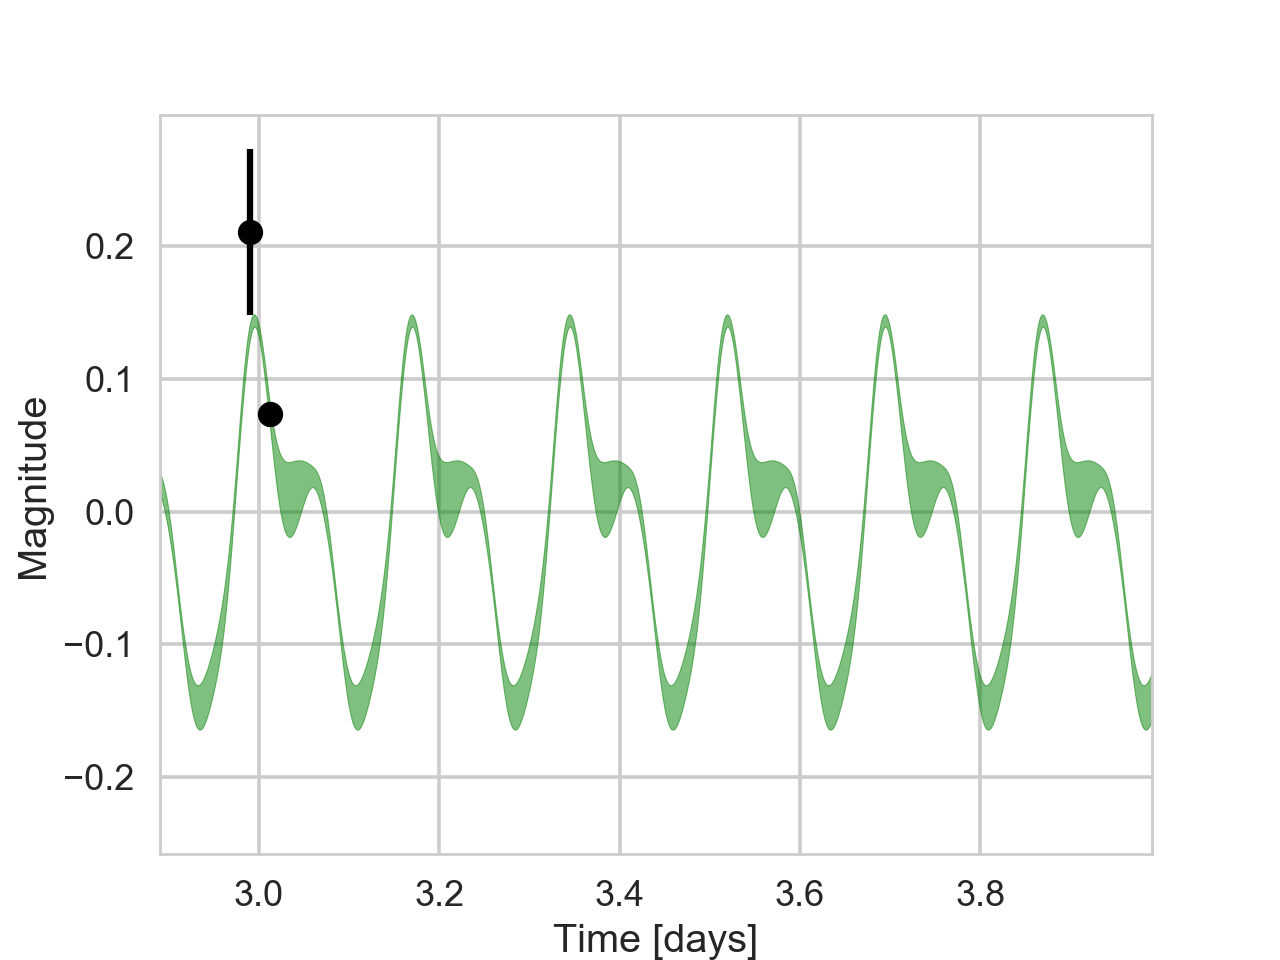

In [232]:
x = np.linspace(np.min(time)-0.1, np.min(time)+1.0, 2000)
mu, var = gp.predict(mag, x, return_var=True)
std = np.sqrt(var)

plt.figure()
plt.errorbar(time, mag, yerr=mag_err, fmt="o", color="black")
plt.fill_between(x, mu+std, mu-std, color="g", alpha=0.5)

plt.xlim(time.min()-0.1, time.min()+1.0)
plt.xlabel("Time [days]")
plt.ylabel("Magnitude");

What are the best-fit parameters?

In [233]:
gp.get_parameter_dict()

OrderedDict([('kernel:k1:log_constant', -4.014873733943278),
             ('kernel:k2:gamma', 1.9342168604735392),
             ('kernel:k2:log_period', -1.7439437978503165)])

In [234]:
def lnprob(p):
    #m = p[0] # mean
    logamp = p[0] # log amp
    gamma = p[1] # gamma
    log_period = p[2] # log period
    
    #if (p[0] < -0.1) or (p[0] > 0.1):
    #    return -np.inf
    if (p[0] < -10.0) or (p[0] > 5.0):
        return -np.inf
    elif (p[1] < 0.01) or (p[1] > 20.0):
        return -np.inf
    elif (p[2] < np.log(1.0/24.0)) or (p[2] > np.log(1.0)):
        return -np.inf
    else:

        # Update the kernel and compute the lnlikelihood.
        gp.set_parameter_vector(p)
        return gp.lnlikelihood(mag, quiet=True)

In [235]:
lnprob(gp.get_parameter_vector())

51.210824891777705

In [236]:
import emcee

gp.compute(time, mag_err)

# Set up the sampler.
nwalkers, ndim = 36, len(gp)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)


In [237]:
# Initialize the walkers.
p0 = gp.get_parameter_vector() + 0.0001 * np.random.randn(nwalkers, ndim)

In [238]:
print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 5000)

Running burn-in


<IPython.core.display.Javascript object>


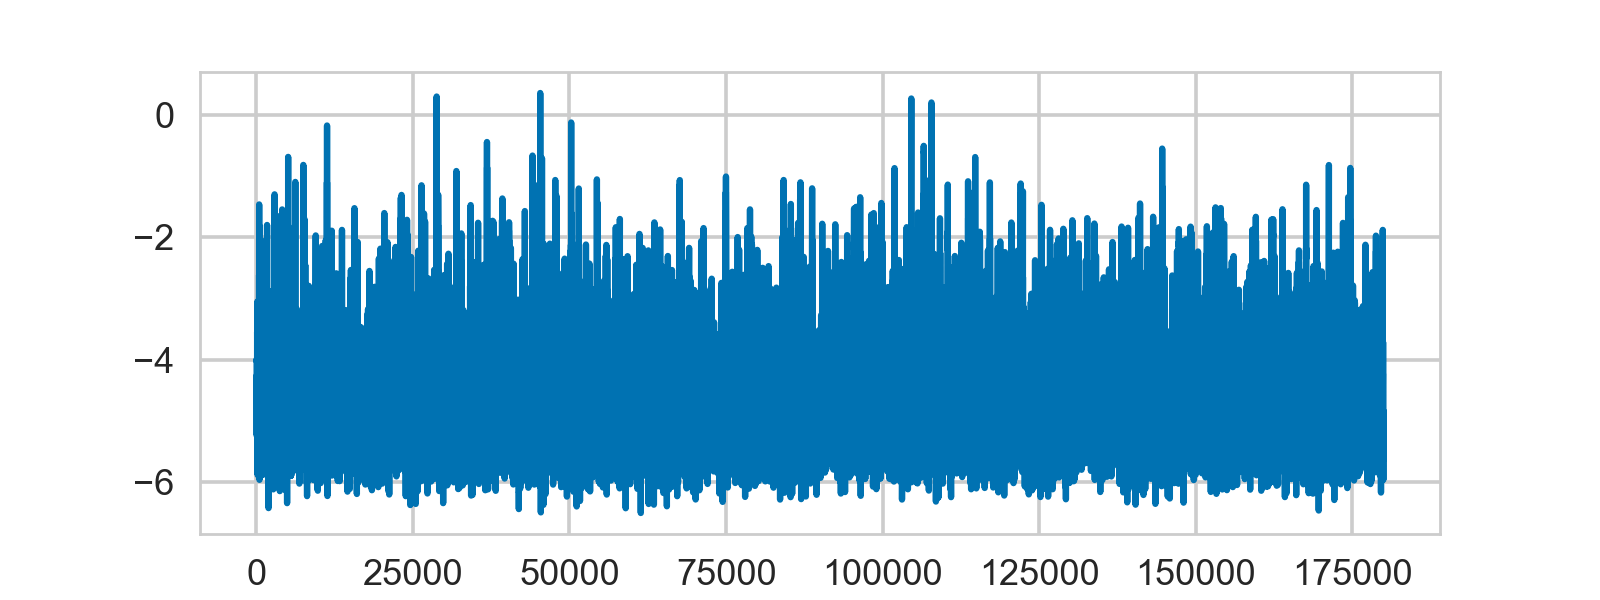

<IPython.core.display.Javascript object>


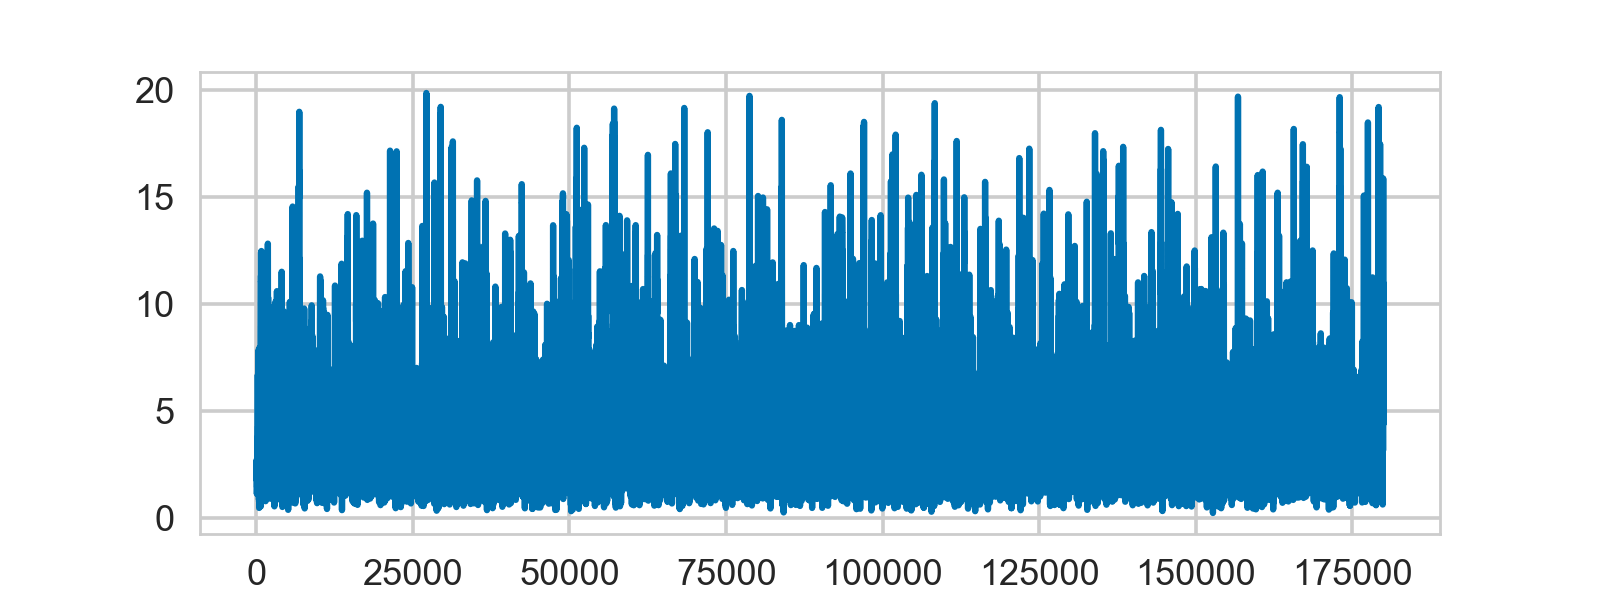

<IPython.core.display.Javascript object>


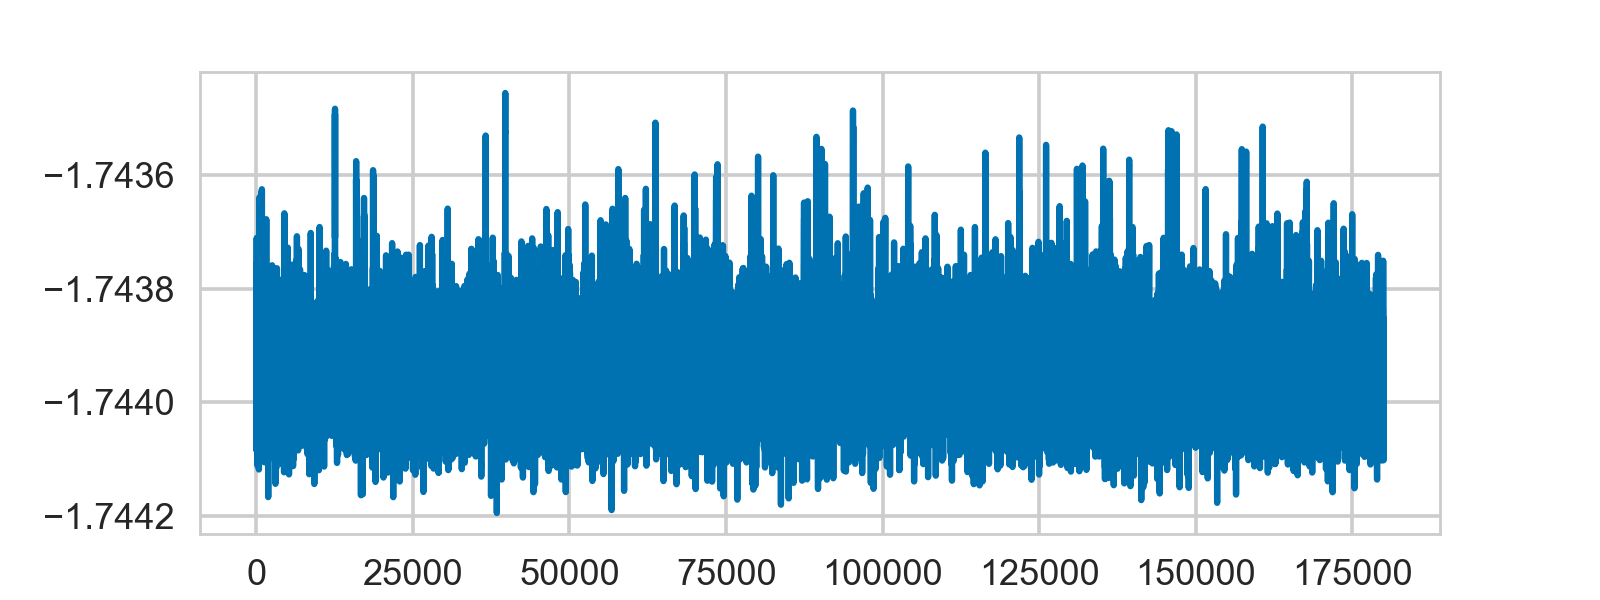

In [239]:
for i in range(sampler.flatchain.shape[1]):
    fig, ax = plt.subplots(1, 1, figsize=(8,3))
    ax.plot(sampler.flatchain[:,i])

In [ ]:
sampler.reset()
print("Running production chain")
sampler.run_mcmc(p0, 2000);

Running production chain


In [ ]:
for i in range(sampler.flatchain.shape[1]):
    fig, ax = plt.subplots(1, 1, figsize=(8,3))
    ax.plot(sampler.flatchain[:,i])

<IPython.core.display.Javascript object>


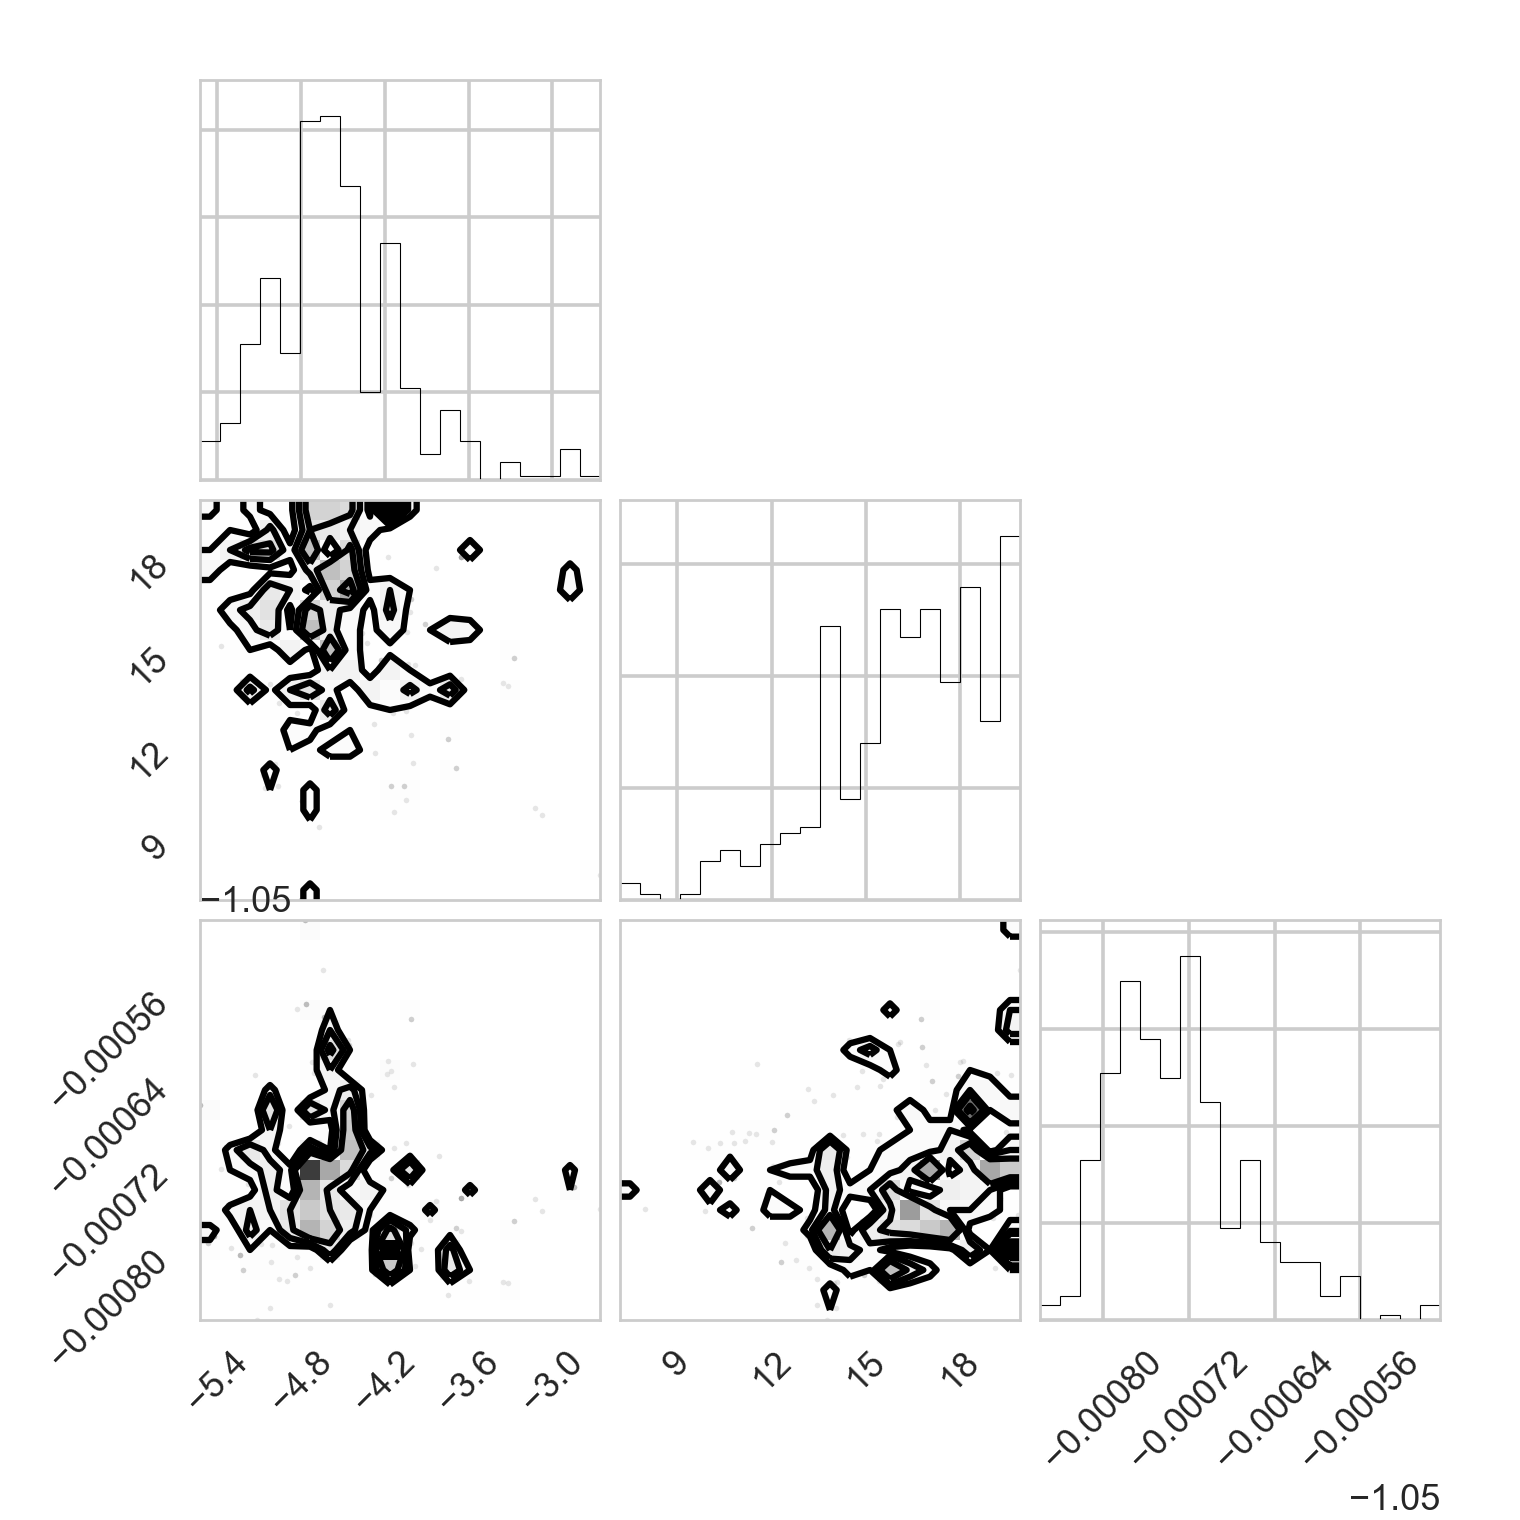

In [199]:
corner.corner(sampler.flatchain[-500:,:]);

In [200]:
time_phased = time/(4.196/24.0)

In [201]:
time_phased = (time_phased - np.floor(time_phased))*(4.196/24.0)

In [202]:
post_p = np.exp(sampler.flatchain[-5000:, -1])

In [203]:
np.mean(post_p*24.0)

8.392019485136677

In [204]:
np.std(post_p*24.0)

0.0006438386856820957

<IPython.core.display.Javascript object>


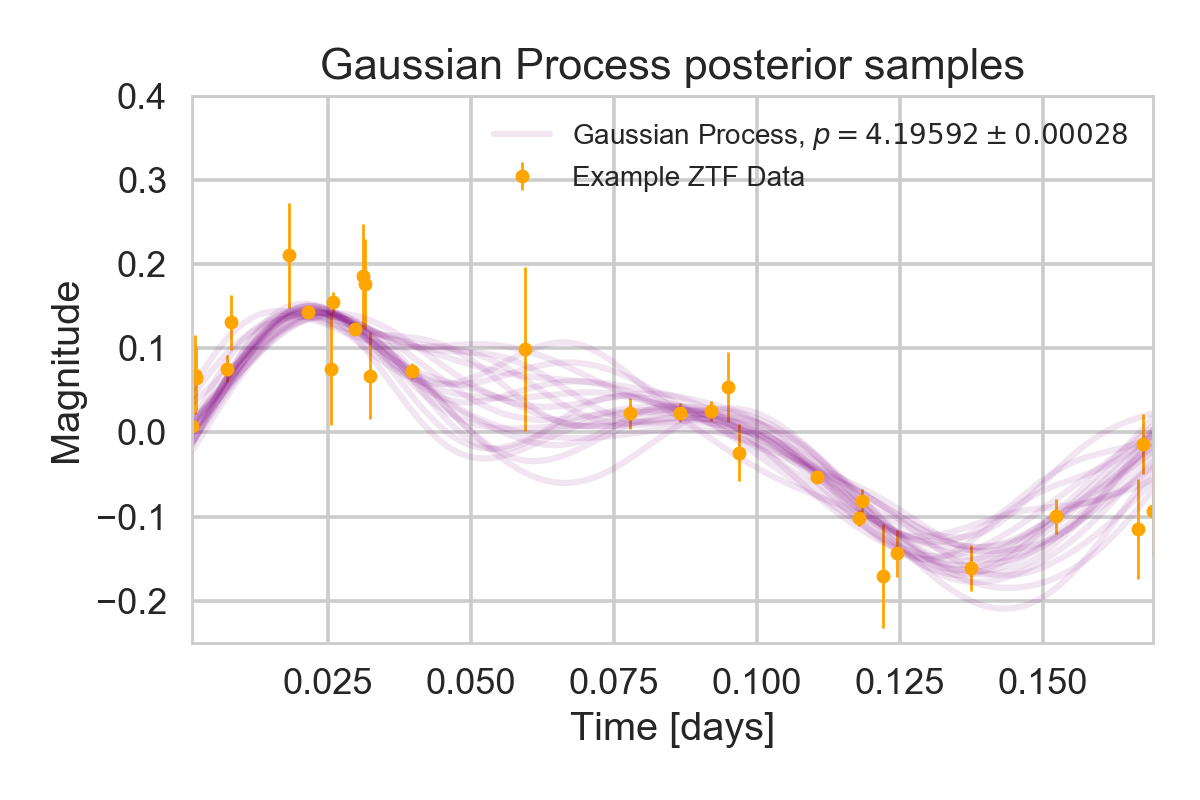

<module 'matplotlib.pyplot' from '/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [205]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

x = np.linspace(time_phased.min(), time_phased.max(), 500)
ax.errorbar(time_phased, mag, yerr=mag_err, fmt="o", c="orange", ms=5, lw=1,
            label="Example ZTF Data")

np.random.seed(180401)
for i in range(20):
    # Choose a random walker and step.
    w = np.random.randint(5000)
    
    gp.set_parameter_vector(sampler.flatchain[-5000+w, :])

    # Plot a single sample.
    if i == 0:
        ax.plot(x, gp.sample_conditional(mag, x), "purple", 
                alpha=0.1, label=r"Gaussian Process, $p=4.19592 \pm 0.00028$")
    else:
        ax.plot(x, gp.sample_conditional(mag, x), "purple", alpha=0.1)

#ax.vlines(time[0]+4.0/24.0, 14.7, 15.3, lw=3, color="black")
ax.legend(fontsize=10, loc=1)
ax.set_xlim(time_phased.min(), np.max(x))
ax.set_ylim(-0.25, 0.4)
ax.set_xlabel("Time [days]")
ax.set_ylabel("Magnitude");
ax.set_title("Gaussian Process posterior samples")
plt.tight_layout()
plt